Collaborators: Margaux Masson-Forsythe

This notebook aims to be used as a "backend/interactive" notebook in collaboration with Task 7. 

Goals: 
1.   Get ROI around lat/lon for 3 GEE datasets
2.   Use the ROIs for generating the histogram
3.   Use this hist as input of the pre trained CNN
4.   Get result back (yield)


### Imports


In [1]:
!pip install rasterio && pip install wget

In [2]:
import ee
import time
import sys
import rasterio
import wget 

from tensorflow.keras import datasets, layers, models
# from unidecode import unidecode
import argparse
import os.path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import random
import csv
try:
    from google.colab.patches import cv2_imshow
except:
    from cv2 import imshow as cv2_imshow
#initialize google earth engine
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()


In [3]:
from google.colab import drive
# TODO: solution not to use google drive?
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### User input

In [4]:
# GPS Coordinates: user input
gpslon = -15.80724333
gpslat = 12.68548667

year = 2017
crop_type = 'maize'

### Function


In [5]:
def appendBand(current, previous):
    # Rename the band
    previous=ee.Image(previous)
    current = current.select(IMG_COLLECTION_BANDS[img_collection_index])
    # Append it to the result (Note: only return current item on first element/iteration)
    accum = ee.Algorithms.If(ee.Algorithms.IsEqual(previous,None), current, previous.addBands(ee.Image(current)))
    # Return the accumulation
    return accum

def export_to_cloud(img, fname, folder, expregion, eeuser=None, scale=10):
  task = ee.batch.Export.image.toDrive(**{
      'image': img.clip(expregion),
      'description':fname, 
      'folder':folder, 
      'fileNamePrefix':fname, 
      'dimensions':None, 
      'region':expregion.geometry().bounds().getInfo()['coordinates'],
      'scale':scale, 
      'crs':'EPSG:4326', 
      'crsTransform':None, 
      'maxPixels':1e13
  })
  task.start()
  while task.status()['state'] == 'RUNNING':
    print('Running...')
    time.sleep(20)
  print('Done.'.format(task.status()))
  time.sleep(20)
  return img.clip(expregion)

def export_images_collection_ROI_lat_long(square, name, collection_name, folder_name_drive, only_download_first_image=True, debug=False, scale=100):
    image_collection = IMG_COLLECTIONS[img_collection_index]
    start_date = str(year) + '-01-01'
    end_date = str(int(year)+1) + '-01-01'
    # Get ImageCollection
    imgcoll = ee.ImageCollection(image_collection) \
      .filterDate(start_date,end_date)\
        
    # appends timestamps into bands
    img=imgcoll.iterate(appendBand)
    img=ee.Image(img)
    totalImages = imgcoll.size().getInfo()
    print("Total count of images in the collection:{} for the date range: {} - {}".format(totalImages, start_date, end_date))
      
    img_cloud = export_to_cloud(img, name, folder_name_drive, ee.Feature(square), scale=scale)
    return img_cloud.clip(ee.Feature(square))

def export_and_get_img_in_Drive(collection_name):
  name = 'square_img_yield_prediction_' + collection_name
  export_images_collection_ROI_lat_long(square, name, collection_name, folder_name_drive, only_download_first_image=True, debug=True, scale=150)
  time.sleep(60) # wait for image to be exported to Drive
  path = "/content/drive/MyDrive/" + folder_name_drive + "/" + name + '.tif'
  print(path)
  image_drive = rasterio.open(path).read()
  image_drive = np.transpose(image_drive, (1, 2, 0))
  print(image_drive.shape)
  plt.figure(figsize=(10, 10))
  plt.suptitle("first bands in image -- total bands: {}".format(image_drive.shape[-1]))
  if collection_name.lower() != 'copernicus':
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_drive[:,:,i])
      plt.axis("off")
    plt.show()
  else:
    plt.imshow(image_drive[:,:,0])
  return image_drive

### Get ROI around GPS coordinates

In [6]:
# name of GEE collections:
IMG_COLLECTIONS = ['MODIS/006/MOD09A1', 'MODIS/006/MYD11A2', 'COPERNICUS/Landcover/100m/Proba-V-C3/Global']
# Images codes -- description
IMG_COLLECTION_CODES = ['reflectance', 'temperature', 'copernicus']

# Bands that will be selected in each collection
IMG_COLLECTION_BANDS = [['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'], 
                        ['LST_Day_1km', 'LST_Night_1km'], 
                        ['discrete_classification']]

folder_name_drive = 'Yield_prediction_GPS_coordinates' 

point = ee.Geometry.Point(gpslon, gpslat)
hectares = 15000 
areaM2 = hectares * 10000  # 1 ha = 10000 m2
square = point.buffer(ee.Number(areaM2).sqrt().divide(2), 1).bounds()

Total count of images in the collection:46 for the date range: 2017-01-01 - 2018-01-01
Done.
/content/drive/MyDrive/Yield_prediction_GPS_coordinates/square_img_yield_prediction_reflectance.tif
(83, 84, 322)


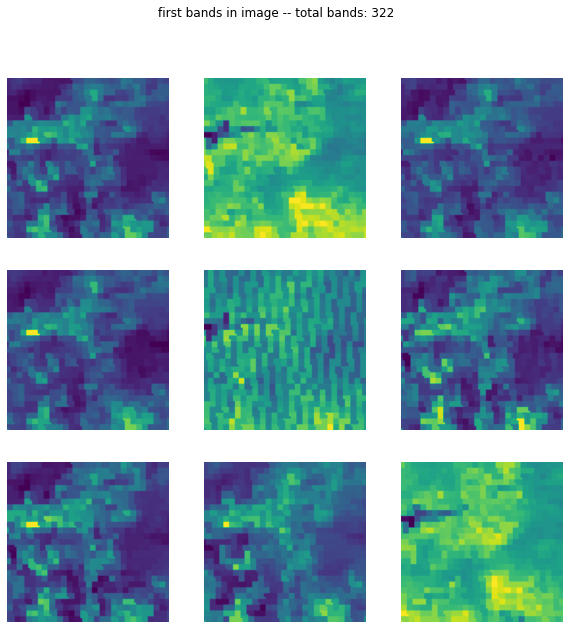

In [7]:
collection_name = 'reflectance'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
# TODO: not getting image from GEE and google drive ? 
reflectance_img = export_and_get_img_in_Drive(collection_name)

Total count of images in the collection:46 for the date range: 2017-01-01 - 2018-01-01
Done.
/content/drive/MyDrive/Yield_prediction_GPS_coordinates/square_img_yield_prediction_temperature.tif
(83, 84, 92)


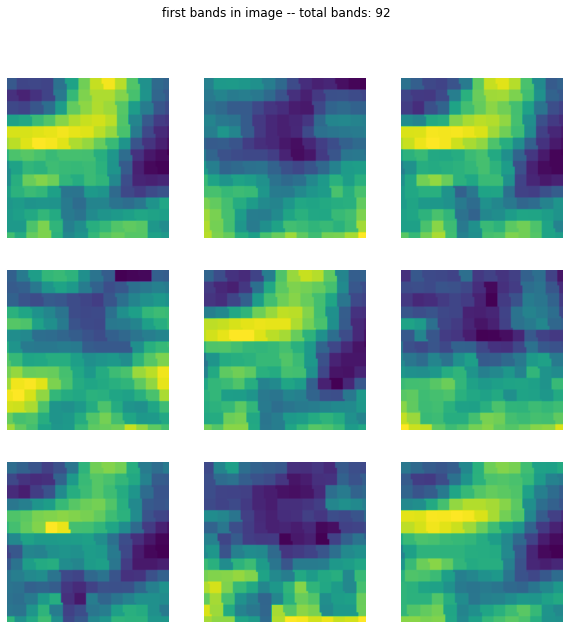

In [9]:
collection_name = 'temperature'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
temperature_img = export_and_get_img_in_Drive(collection_name)

Total count of images in the collection:1 for the date range: 2017-01-01 - 2018-01-01
Done.
/content/drive/MyDrive/Yield_prediction_GPS_coordinates/square_img_yield_prediction_copernicus.tif
(83, 84, 1)


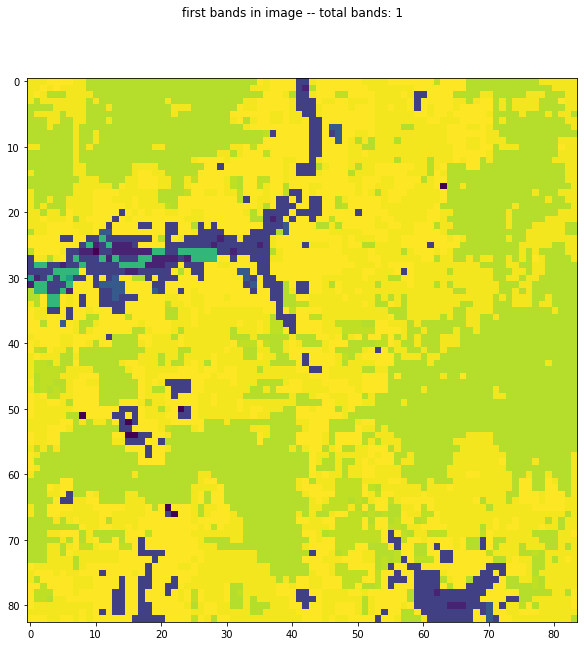

In [12]:
collection_name = 'copernicus'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
landcover_mask = export_and_get_img_in_Drive(collection_name)


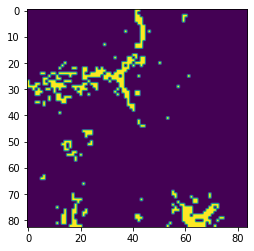

In [13]:
CROP_LABEL = 40 # label of cropland class 
landcover_mask = landcover_mask[:,:,0]
landcover_mask[landcover_mask != CROP_LABEL] = 0
landcover_mask[landcover_mask == CROP_LABEL] = 1
plt.imshow(landcover_mask)

### Generate histograms

#### Functions histograms

In [14]:
### Function calc_32_bins_histograms ####
# Generates 32-bins pixel counts histograms from GeoTiff
# The resulting histogram's size is [normalized bin values, number of timestamps, band]
# NB: number of timestamps N = N-day composite of GEE layers
# To be able to concanete histograms, all GeoTiff used need to have the same number of timestamps
# otherwise the sizes of the histrograms won't match
#
# Input:
# image: GeoTiff layer
# num_bands : number of bands combined in the image
# bin_seq_list: lindscape list to create the corresponding histograms
# weeks: time in weeks of the months before harvest. for 1 year: weeks = [0,46]
# for first week June to last week August: weeks = [19,30]
def calc_32_bins_histograms(image, num_bands, bin_seq_list, weeks=[0,46]):
    num_bins = 32
    num_times = image.shape[2] // num_bands
    hist = np.zeros([num_bins, num_times, num_bands])
    for i in range(image.shape[2]):
        band = i % num_bands
        density, _ = np.histogram(image[:, :, i], bin_seq_list[band], density=False)
        total = density.sum()  # normalize over only values in bins
        hist[:, i // num_bands, band] = density / float(total) if total > 0 else 0
    return hist[:, weeks[0]:weeks[1]]

In [15]:
#### Function mask_image
# Removes non-crop pixels in all 2D slices of 3D image tensor of shape X x Y x (bands/time)
def mask_image(img, mask, num_bands):
    num_imgs = img.shape[2]//num_bands
    assert num_imgs == int(num_imgs)
    for t in range(num_imgs):
        for b in range(num_bands):
            img[:, :, t*num_bands + b] = np.multiply(img[:, :, t*num_bands + b], mask)
    return img

In [16]:
def get_weeks_for_crop_type(crop_type):
  weeks = []
  if crop_type.lower() == "maize":
    weeks = [19,30] # first week of June to last week of August
  if crop_type.lower() == "millet":
    weeks = [21,30] # first week of June to last week of August
  return weeks

def get_bin_seq_and_num_bands_for_image_collection(image_collection_name):
  print(image_collection_name)
  if image_collection_name == 'reflectance':
    bin_seq_list = [np.linspace(1, 2200, 33),
            np.linspace(900, 4999, 33),
            np.linspace(1, 1250, 33),
            np.linspace(150, 1875, 33),
            np.linspace(750, 4999, 33),
            np.linspace(300, 4999, 33),
            np.linspace(1, 4999, 33)]
    num_bands = 7
  if image_collection_name == 'temperature':
    bin_seq_list = [np.linspace(13000,16500,33), np.linspace(13000,15500,33)]
    num_bands = 2
  return bin_seq_list, num_bands

In [17]:
def get_histograms(image_collection_name, image_img_collection, landcover_mask):
  weeks = get_weeks_for_crop_type(crop_type)
  bin_seq, num_bands = get_bin_seq_and_num_bands_for_image_collection(image_collection_name)

  masked_image = mask_image(image_img_collection, landcover_mask, num_bands)
  print("Shape masked image: {}".format(masked_image.shape))
  hist = calc_32_bins_histograms(masked_image, num_bands, bin_seq, weeks)

  print("Shape histogram {}".format(hist.shape))
  plt.suptitle("Histograms")
  for i in range(hist.shape[-1]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hist[:, :, i])
  plt.show()
  plt.figure(1)
  plt.suptitle('Image cropped and first band histogram')
  plt.subplot(121)
  plt.imshow(masked_image[:, :, 0])
  plt.subplot(122)
  plt.imshow(hist[:, :, 0])
  return hist


#### Get histograms and visualise 

reflectance
Shape masked image: (83, 84, 322)
Shape histogram (32, 11, 7)


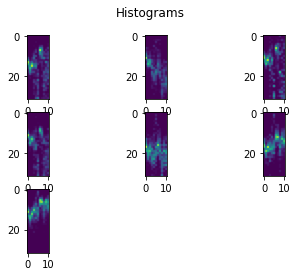

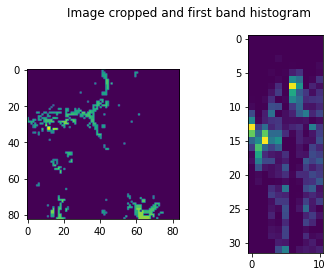

In [18]:
hist_reflectance = get_histograms('reflectance', reflectance_img, landcover_mask)

temperature
Shape masked image: (83, 84, 92)
Shape histogram (32, 11, 2)


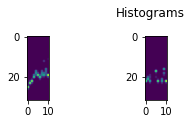

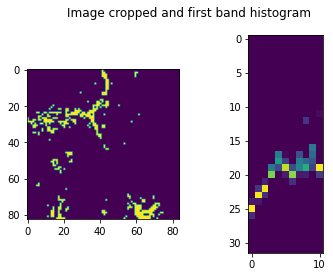

In [19]:
hist_temperature = get_histograms('temperature', temperature_img, landcover_mask)

In [20]:
hists_concat = np.concatenate((hist_reflectance, hist_temperature), axis=2)
print(hists_concat.shape)

(32, 11, 9)


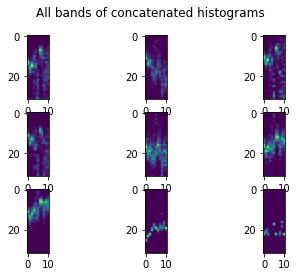

In [21]:
plt.suptitle("All bands of concatenated histograms")
for i in range(hists_concat.shape[-1]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hists_concat[:, :, i])
plt.show()

In [22]:
histogram_transposed = np.transpose(hists_concat, (1,0,2))
timestamps = []
for j in range(hists_concat.shape[1]): # going through all timestamps
  timestamps.append(np.expand_dims(histogram_transposed[j], axis=0))
print("{} timestamps of shape (1,{},{})".format(len(timestamps), timestamps[0].shape[0], timestamps[0].shape[1]))

input_shape_cnn_lstm = (11, 1, 32, 9)
print("input_shape_cnn_lstm: {} = (timestamps*1*bins*bands)".format(input_shape_cnn_lstm))
input_shape_cnn = (1, 32, 9)
print("input_shape_cnn: {} = (1*bins*bands)".format(input_shape_cnn))

11 timestamps of shape (1,1,32)
input_shape_cnn_lstm: (11, 1, 32, 9) = (timestamps*1*bins*bands)
input_shape_cnn: (1, 32, 9) = (1*bins*bands)


### Model load pre trained weights

In [23]:
if crop_type.lower() == 'maize':
  wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN/checkpoint_b1_maize_best.h5", "./checkpoint.h5")


In [24]:
# CNN-LSTM WIP
# https://www.mdpi.com/1424-8220/19/20/4363/htm
from keras.layers.wrappers import TimeDistributed
from keras.layers import *
from keras import regularizers
model=models.Sequential()

model.add(TimeDistributed(Conv2D(32, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001),
                                  input_shape=(input_shape_cnn)), input_shape=input_shape_cnn_lstm))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Conv2D(64, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=True, activation='relu', dropout=0.25));

model.add(TimeDistributed(Dense(64)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(1)))
model.add(GlobalAveragePooling1D(name="global_avg_flow"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 11, 1, 31, 32)     608       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 1, 31, 32)     128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 1, 15, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 1, 14, 64)     4160      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 11, 1, 14, 64)     256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 11, 1, 7, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 11, 448)           0

In [25]:
model.load_weights('/content/checkpoint.h5')

### Prediction

predictions shape: ()
yield for maize predicted: 0.5513163805007935 T/ha for GPS coordinates 12.68548667 lat / -15.80724333 lon year 2017


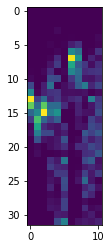

In [26]:
plt.imshow(hists_concat[:,:,0])
yield_predicted = model.predict(np.array([timestamps]))[0][0]
print("predictions shape:", yield_predicted.shape)
print("yield for {} predicted: {} T/ha for GPS coordinates {} lat / {} lon year {}".format(crop_type,yield_predicted, gpslat, gpslon, year))